In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.cluster import (KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering,
                             MeanShift, OPTICS, AffinityPropagation, Birch)
from sklearn.mixture import GaussianMixture
import hdbscan
from pyclustering.cluster.clarans import clarans
from minisom import MiniSom

In [2]:
data = {
    "CustomerID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    "Gender": ["Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Female",  "Male", "Female", "Female", "Female", "Male", "Male", "Female"],
    "Age": [19, 21, 20, 23, 31, 22, 35, 23, 64, 30, 67, 35, 58, 24, 37, 22, 35],
    "Annual Income (k$)": [15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21],
    "Spending Score (1-100)": [39, 81, 6, 77, 40, 76, 6, 94, 3, 72, 14, 99, 15, 77, 13, 79, 35]
}

df = pd.DataFrame(data)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
categorical_columns = ['Gender']
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(), categorical_columns)
])

X_processed = preprocessor.fit_transform(df)

In [4]:
def evaluate(name, labels, X):
    unique_labels = set(labels)
    if -1 in unique_labels:
        n_clusters = len(unique_labels) - 1
    else:
        n_clusters = len(unique_labels)
    
    if n_clusters < 2 or n_clusters >= len(X):
        return {'Model': name, 'Silhouette': None, 'DBI': None, 'CH Index': None}
    
    if -1 in unique_labels:
        filtered_indices = [i for i, lbl in enumerate(labels) if lbl != -1]
        X_filtered = X[filtered_indices]
        labels_filtered = labels[filtered_indices]
    else:
        X_filtered = X
        labels_filtered = labels
    
    return {
        'Model': name,
        'Silhouette': silhouette_score(X_filtered, labels_filtered),
        'DBI': davies_bouldin_score(X_filtered, labels_filtered),
        'CH Index': calinski_harabasz_score(X_filtered, labels_filtered)
    }

In [5]:
results = []

models = [
    ("KMeans", KMeans(n_clusters=4, random_state=42).fit(X_processed).labels_),
    ("Agglomerative", AgglomerativeClustering(n_clusters=4).fit(X_processed).labels_),
    ("Birch", Birch(n_clusters=4).fit(X_processed).labels_),
    ("Spectral", SpectralClustering(n_clusters=4, assign_labels='kmeans', random_state=42).fit(X_processed).labels_),
    ("DBSCAN", DBSCAN(eps=1.5, min_samples=5).fit(X_processed).labels_),
    ("OPTICS", OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05).fit(X_processed).labels_),
    ("AffinityPropagation", AffinityPropagation(random_state=42).fit(X_processed).labels_),
    ("MeanShift", MeanShift().fit(X_processed).labels_),
    ("GaussianMixture", GaussianMixture(n_components=4, random_state=42).fit(X_processed).predict(X_processed)),
    ("HDBSCAN", hdbscan.HDBSCAN(min_cluster_size=10).fit(X_processed).labels_)
]

In [6]:
clarans_instance = clarans(X_processed.tolist(), number_clusters=4, numlocal=3, maxneighbor=5)
clarans_instance.process()
clarans_clusters = clarans_instance.get_clusters()
clarans_labels = np.zeros(len(X_processed))
for i, cluster in enumerate(clarans_clusters):
    clarans_labels[cluster] = i
models.append(("CLARANS", clarans_labels))

In [7]:
som = MiniSom(x=10, y=10, input_len=X_processed.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_processed)
som.train_random(X_processed, 100)
som_labels = np.array([np.ravel_multi_index(som.winner(x), (10, 10)) for x in X_processed])
models.append(("SOM", som_labels))

for name, labels in models:
    results.append(evaluate(name, labels, X_processed))

In [8]:
results_df = pd.DataFrame(results).sort_values(by='Silhouette', ascending=False)
results_df

,Model,Silhouette,DBI,CH Index
2,Birch,0.345902,0.796297,10.212316
1,Agglomerative,0.317061,0.896524,10.635898
6,AffinityPropagation,0.309818,1.029299,10.907094
3,Spectral,0.309777,0.949637,8.997221
0,KMeans,0.290073,0.984158,10.033877
8,GaussianMixture,0.290073,0.984158,10.033877
7,MeanShift,0.288649,1.056563,9.216441
10,CLARANS,0.186611,1.078754,7.482082
4,DBSCAN,NaN,NaN,NaN
5,OPTICS,NaN,NaN,NaN


In [9]:
# Pick best model by Silhouette score
best_model_name = results_df.iloc[0]['Model']

best_model_labels = None
for name, labels in models:
    if name == best_model_name:
        best_model_labels = labels
        break

# Assign best labels to df and save
df['Best_Cluster'] = best_model_labels
df.to_csv('clustered_customers.csv', index=False)

print(f"Best clustering model: {best_model_name}")
print("Clustered data saved to 'clustered_customers.csv'")

Best clustering model: Birch
Clustered data saved to 'clustered_customers.csv'


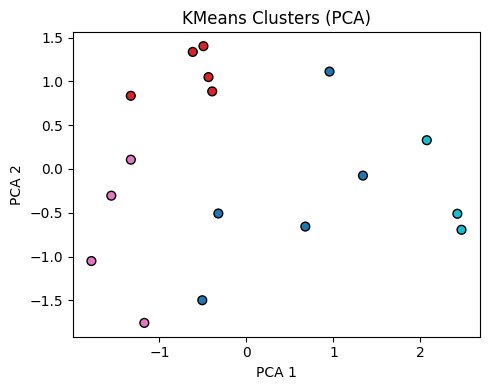

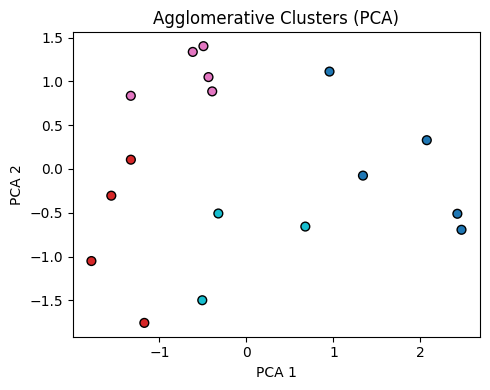

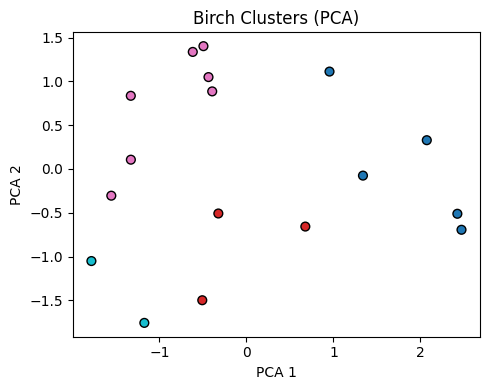

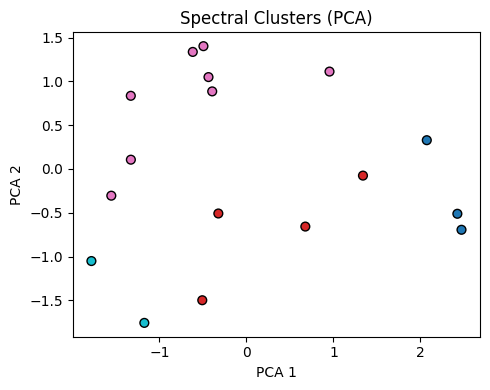

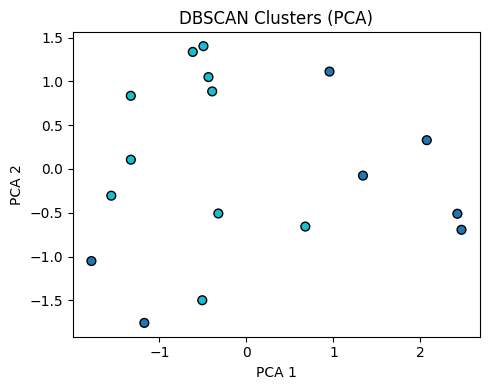

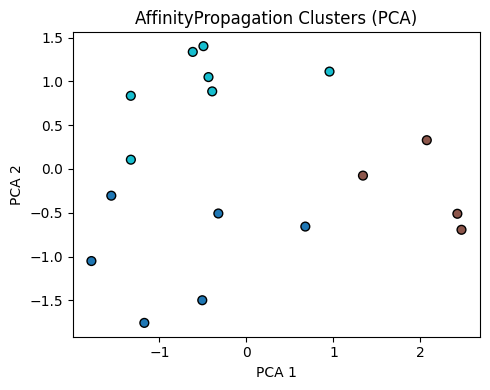

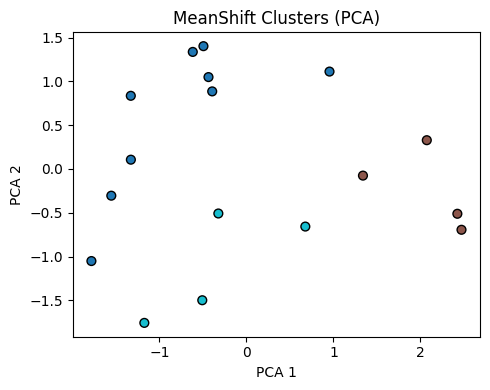

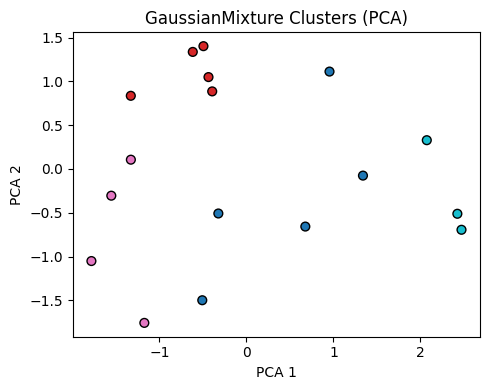

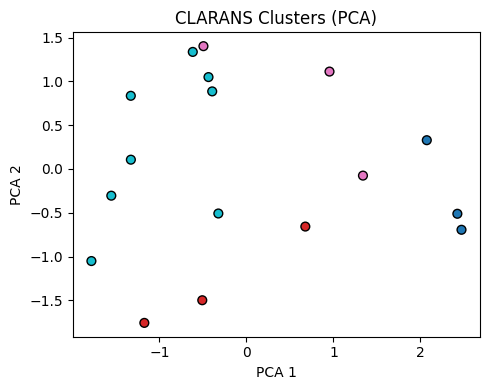

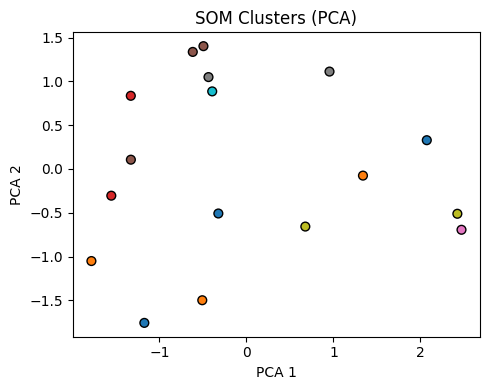

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce features to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Plotting function
def plot_clusters(name, labels):
    plt.figure(figsize=(5, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=40, edgecolor='k')
    plt.title(f'{name} Clusters (PCA)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.tight_layout()
    plt.show()

# Visualize all
for name, labels in models:
    if len(set(labels)) >= 2:
        plot_clusters(name, labels)